<a href="https://colab.research.google.com/github/EfanovNikita/knee_arthritis/blob/master/knee_arthritis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [28]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [29]:
!kaggle datasets download -d hafiznouman786/annotated-dataset-for-knee-arthritis-detection

!unzip "annotated-dataset-for-knee-arthritis-detection.zip"

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/annotated-dataset-for-knee-arthritis-detection
License(s): CC0-1.0
annotated-dataset-for-knee-arthritis-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  annotated-dataset-for-knee-arthritis-detection.zip
replace Training/0Normal/NormalG0 (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [30]:
train_data = tf.keras.utils.image_dataset_from_directory(
    './Training',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset='training',
    label_mode='categorical',
    seed=124
)
val_data = tf.keras.utils.image_dataset_from_directory(
    './Training',
    batch_size=None,
    image_size=(224, 224),
    validation_split=0.2,
    subset='validation',
    label_mode='categorical',
    seed=124
)
val_data, test_data = tf.keras.utils.split_dataset(val_data, left_size=0.8)
val_data = val_data.batch(32)
test_data = test_data.batch(32)
print(train_data)
print(val_data)
print(train_data.class_names)
class_names = train_data.class_names

Found 1650 files belonging to 5 classes.
Using 1320 files for training.
Found 1650 files belonging to 5 classes.
Using 330 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']


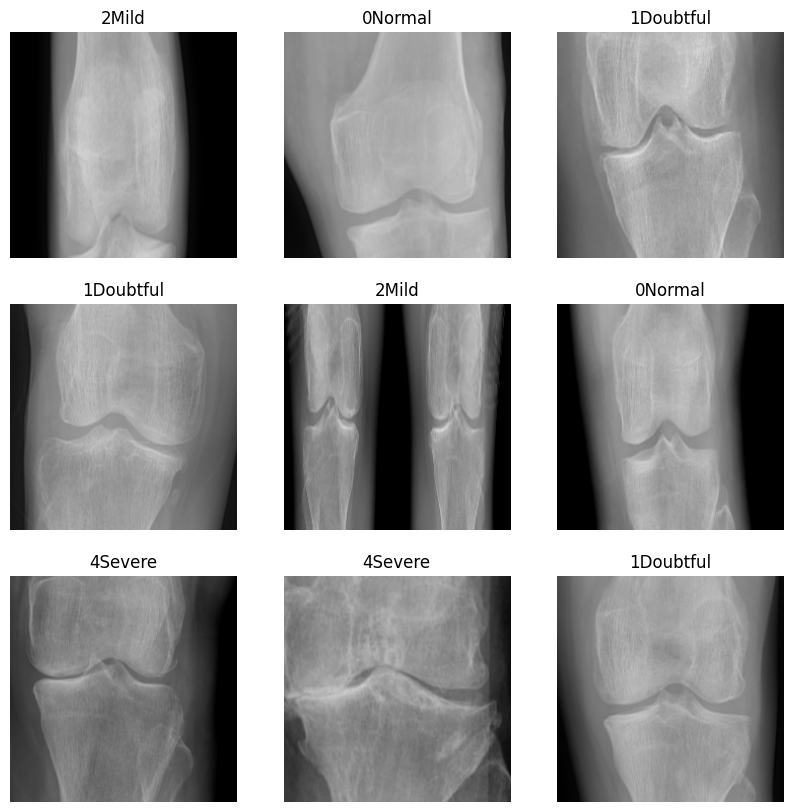

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[list(labels[i]).index(1)])
    plt.axis("off")

In [32]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

In [33]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
callback1 = tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    mode='max', min_delta=0.001,
                    patience = 10)

In [35]:
epochs=100
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback1]
)

Epoch 1/100
42/42 [==============================] - 5s 84ms/step - loss: 1.7718 - accuracy: 0.2955 - val_loss: 1.5409 - val_accuracy: 0.3220
Epoch 2/100
42/42 [==============================] - 4s 77ms/step - loss: 1.4819 - accuracy: 0.3273 - val_loss: 1.4884 - val_accuracy: 0.3371
Epoch 3/100
42/42 [==============================] - 4s 75ms/step - loss: 1.4306 - accuracy: 0.3652 - val_loss: 1.4792 - val_accuracy: 0.3295
Epoch 4/100
42/42 [==============================] - 4s 97ms/step - loss: 1.4119 - accuracy: 0.3780 - val_loss: 1.4198 - val_accuracy: 0.3864
Epoch 5/100
42/42 [==============================] - 3s 73ms/step - loss: 1.3658 - accuracy: 0.4076 - val_loss: 1.3861 - val_accuracy: 0.4015
Epoch 6/100
42/42 [==============================] - 3s 73ms/step - loss: 1.3007 - accuracy: 0.4318 - val_loss: 1.3888 - val_accuracy: 0.3750
Epoch 7/100
42/42 [==============================] - 4s 77ms/step - loss: 1.2601 - accuracy: 0.4492 - val_loss: 1.3617 - val_accuracy: 0.4129
Epoch 

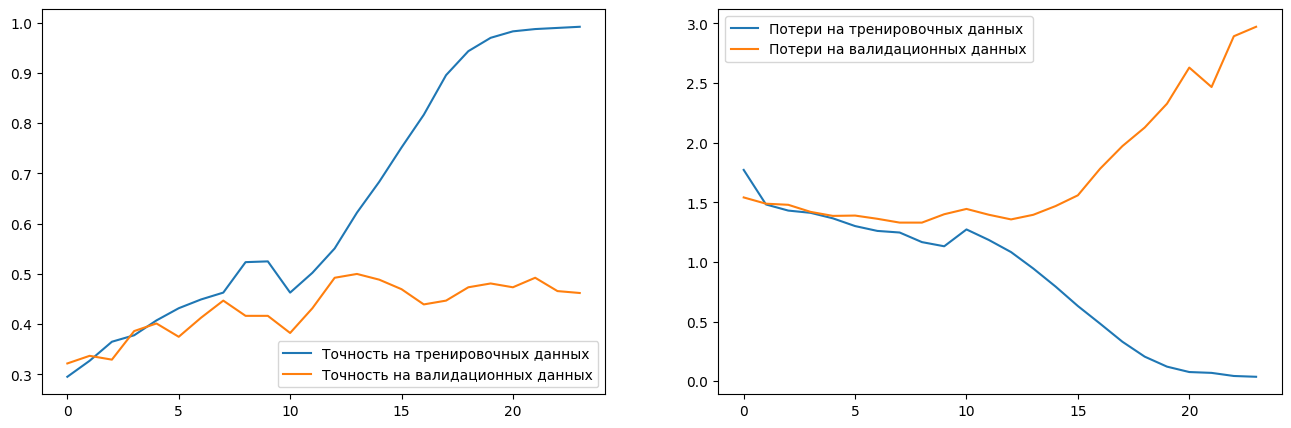

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на тренировочных данных')
plt.plot(epochs_range, val_acc, label='Точность на валидационных данных')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на тренировочных данных')
plt.plot(epochs_range, val_loss, label='Потери на валидационных данных')
plt.legend(loc='upper left')

На этих графиках видно, что примерно после 10 эпохи точность на валидационных данных перестает расти, а потери только возрастают. Это может свидетельствовать о переобучении модели. Попробуем исправить это добавив в модель слой Dropout, который будет случайным образом "отключать" некоторые нейроны. Также добавим один слой BatchNormalization, чтобы нормализировать выходные данные внутреннего слоя.

In [37]:
model_2 = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

In [38]:
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
epochs=100
history = model_2.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback1]
)

Epoch 1/100
42/42 [==============================] - 6s 89ms/step - loss: 5.1921 - accuracy: 0.2765 - val_loss: 1.6060 - val_accuracy: 0.2576
Epoch 2/100
42/42 [==============================] - 4s 97ms/step - loss: 1.4727 - accuracy: 0.3765 - val_loss: 1.6033 - val_accuracy: 0.2576
Epoch 3/100
42/42 [==============================] - 4s 85ms/step - loss: 1.4138 - accuracy: 0.3735 - val_loss: 1.5976 - val_accuracy: 0.2576
Epoch 4/100
42/42 [==============================] - 4s 88ms/step - loss: 1.3269 - accuracy: 0.4348 - val_loss: 1.5951 - val_accuracy: 0.2576
Epoch 5/100
42/42 [==============================] - 4s 85ms/step - loss: 1.2403 - accuracy: 0.4758 - val_loss: 1.5956 - val_accuracy: 0.2576
Epoch 6/100
42/42 [==============================] - 4s 84ms/step - loss: 1.2163 - accuracy: 0.4917 - val_loss: 1.5889 - val_accuracy: 0.2576
Epoch 7/100
42/42 [==============================] - 4s 91ms/step - loss: 1.0578 - accuracy: 0.5492 - val_loss: 1.5775 - val_accuracy: 0.2576
Epoch 

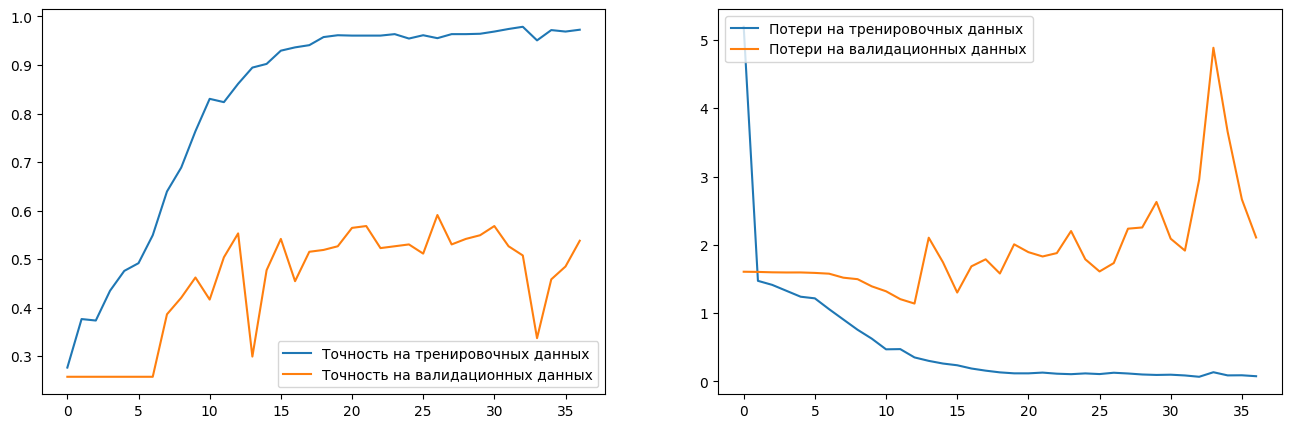

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на тренировочных данных')
plt.plot(epochs_range, val_acc, label='Точность на валидационных данных')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на тренировочных данных')
plt.plot(epochs_range, val_loss, label='Потери на валидационных данных')
plt.legend(loc='upper left')

По данным этих графиков можно сделать вывод. что ситуация не сильно изменилась. Максимальная валидационная точность все также находится около 50%. Попробуем добавить несколько слоев для аугментации данных и еще по одному слою Dropout и BatchNormalization.

In [41]:
model_3 = Sequential([
    layers.RandomFlip('horizontal', input_shape=(224, 224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax'),
])

In [42]:
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
epochs=100
history = model_3.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback1]
)

Epoch 1/100
42/42 [==============================] - 7s 97ms/step - loss: 14.5619 - accuracy: 0.2553 - val_loss: 8.8667 - val_accuracy: 0.1439
Epoch 2/100
42/42 [==============================] - 4s 94ms/step - loss: 2.6920 - accuracy: 0.2894 - val_loss: 9.5230 - val_accuracy: 0.1553
Epoch 3/100
42/42 [==============================] - 5s 108ms/step - loss: 1.6475 - accuracy: 0.3144 - val_loss: 8.3350 - val_accuracy: 0.1515
Epoch 4/100
42/42 [==============================] - 4s 97ms/step - loss: 1.5765 - accuracy: 0.3106 - val_loss: 7.4838 - val_accuracy: 0.1477
Epoch 5/100
42/42 [==============================] - 4s 92ms/step - loss: 1.5660 - accuracy: 0.3106 - val_loss: 5.8698 - val_accuracy: 0.1667
Epoch 6/100
42/42 [==============================] - 4s 92ms/step - loss: 1.5639 - accuracy: 0.3091 - val_loss: 4.1231 - val_accuracy: 0.2652
Epoch 7/100
42/42 [==============================] - 5s 105ms/step - loss: 1.5500 - accuracy: 0.3114 - val_loss: 3.2332 - val_accuracy: 0.3144
Epo

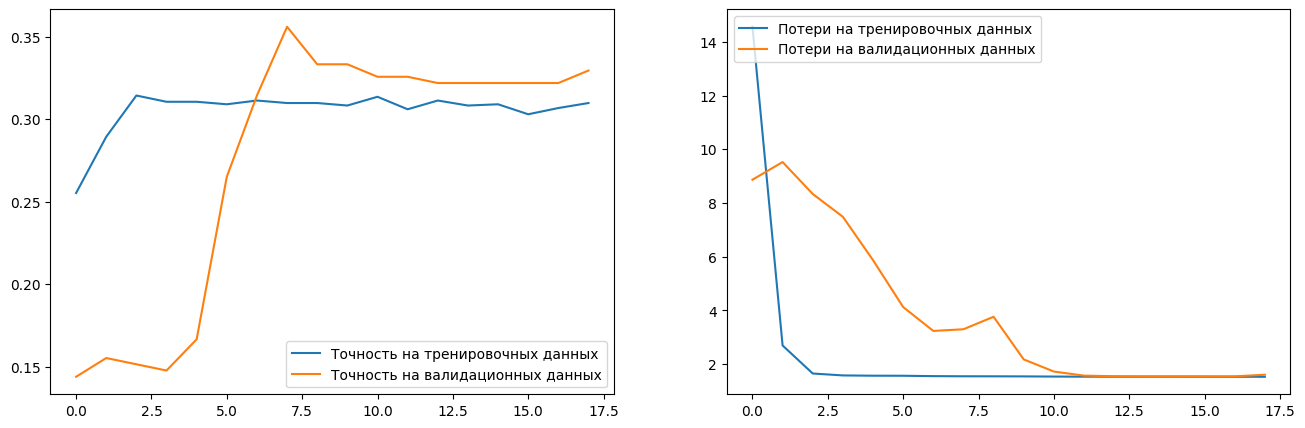

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на тренировочных данных')
plt.plot(epochs_range, val_acc, label='Точность на валидационных данных')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на тренировочных данных')
plt.plot(epochs_range, val_loss, label='Потери на валидационных данных')
plt.legend(loc='upper left')

Как мы видим на этих графиках, наша модель не только не улучшилась, но стала хуже. Теперь точность валидационных данных не выросла больше 40%, а сама модель перестает обучаться даже на тренировочных данных. Попробуем убрать слои аугментации и добавить слой для первичной обработки данных. Этот слой превращает цветное rgb изображение в черно-белое.

In [45]:
model_4 = Sequential([
    layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),
    layers.Rescaling(1./255, input_shape=(224, 224, 1)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax'),
])

In [46]:
model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
epochs=100
history = model_4.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback1]
)

Epoch 1/100
42/42 [==============================] - 7s 107ms/step - loss: 5.7979 - accuracy: 0.2826 - val_loss: 1.6108 - val_accuracy: 0.1326
Epoch 2/100
42/42 [==============================] - 4s 85ms/step - loss: 1.5192 - accuracy: 0.3212 - val_loss: 1.6061 - val_accuracy: 0.2576
Epoch 3/100
42/42 [==============================] - 4s 85ms/step - loss: 1.4546 - accuracy: 0.3470 - val_loss: 1.6033 - val_accuracy: 0.2576
Epoch 4/100
42/42 [==============================] - 5s 104ms/step - loss: 1.3776 - accuracy: 0.4008 - val_loss: 1.6016 - val_accuracy: 0.2576
Epoch 5/100
42/42 [==============================] - 4s 85ms/step - loss: 1.2944 - accuracy: 0.4485 - val_loss: 1.6006 - val_accuracy: 0.2576
Epoch 6/100
42/42 [==============================] - 4s 85ms/step - loss: 1.1927 - accuracy: 0.5045 - val_loss: 1.5959 - val_accuracy: 0.2576
Epoch 7/100
42/42 [==============================] - 5s 109ms/step - loss: 1.1560 - accuracy: 0.5348 - val_loss: 1.5950 - val_accuracy: 0.2576
Epo

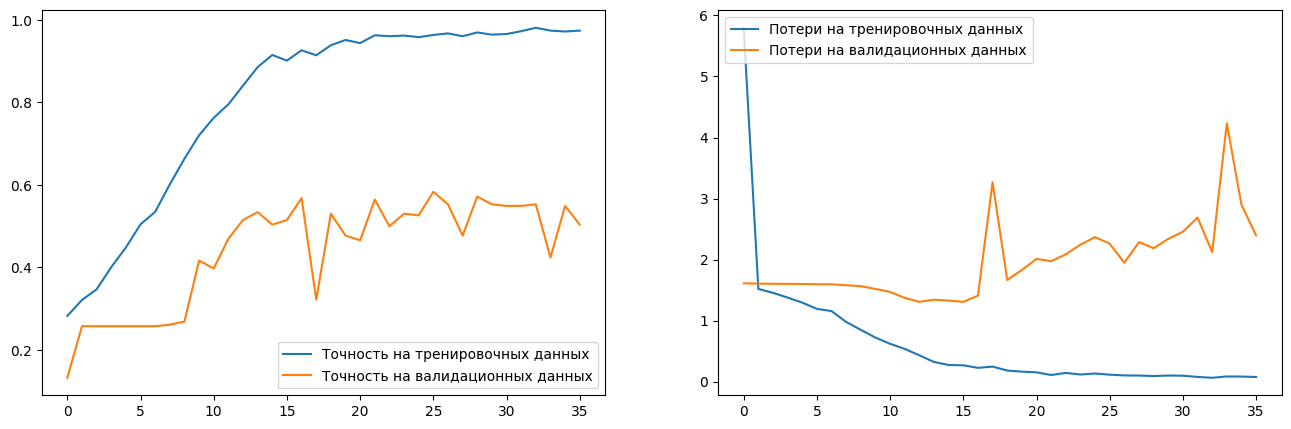

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на тренировочных данных')
plt.plot(epochs_range, val_acc, label='Точность на валидационных данных')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на тренировочных данных')
plt.plot(epochs_range, val_loss, label='Потери на валидационных данных')
plt.legend(loc='upper left')

Как видно на графиках, ситация стала лучше по сравнению с предыдущим результатом. Но по результатам точности на валидационных данных эта модель не превосходит первые две модели. Теперь проверим модели на тестовых данных

In [51]:
print('Точность и потери на тестовых данных')
print('Первая модель')
model.evaluate(test_data)
print('Вторая модель')
model_2.evaluate(test_data)
print('Третья модель')
model_3.evaluate(test_data)
print('Четвертая модель')
model_4.evaluate(test_data)

Точность и потери на тестовых данных
Первая модель
3/3 [==============================] - 0s 16ms/step - loss: 3.0556 - accuracy: 0.5000
Вторая модель
3/3 [==============================] - 0s 19ms/step - loss: 1.9449 - accuracy: 0.5606
Третья модель
3/3 [==============================] - 0s 20ms/step - loss: 1.5828 - accuracy: 0.2879
Четвертая модель
3/3 [==============================] - 0s 17ms/step - loss: 2.8074 - accuracy: 0.4848


[2.807413101196289, 0.4848484992980957]

По результатам видно, что ни одна из моделей не показала хороших результатов. Самый луший результат был у модели со слоями BatchNormalization и Dropout